# SWOT L3 KaRIn Wind Wave Data Products

The SWOT KaRIn Level-3 Wind Wave product (L3_LR_WIND_WAVE) is an innovative product derived from the [Unsmoothed L3_LR_SSH product](https://doi.org/10.24400/527896/A01-2024.003) based on the algorithm presented in Ardhuin et al., 2024. It takes advantage of the KaRIn Low Rate (LR) chain's ability to resolve waves larger than about 500 meters in wavelength (about 18 s) and provides detailed information on the characteristics of these wave regimes, including significant wave height (SWH), dominant wavelength, and wave propagation direction. These regimes are typically associated with long-period swells and extreme events that play a critical role in ocean dynamics, coastal processes, and maritime operations.

SWOT L3_LR_WIND_WAVE product is organized in 2 subproducts:

* Light L3_LR_WIND_WAVE (or lightweight), which includes the spectrum of KaRIn L3 250-m SSHA corrected from instrumental effects, expressed in both cartesian and polar coordinates, the swell partition of the spectrum and the wave parameters integrated over this partition for both WW3 model and KaRIn (significant wave height, wavelength and direction)
* Extended L3_LR_WIND_WAVE, which includes the same variables as the light product below plus the WW3 spectrum in the same frequency grid as the KaRIn spectrum, the KaRIn transfer functions used for correction and some parameters derived from KaRIn observations (coherence, mean backscatter...)


Data can be explored at [Swot LR L3 Wind Wave catalog](https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-wind-wave/v2_0/catalog.html).

For more information about this product, please consult its [User handbook](https://www.aviso.altimetry.fr/fileadmin/documents/data/tools/hdbk_SWOT_L3_LR_WIND_WAVE.pdf).

## Tutorial Objectives
* Download files via AVISO’s THREDDS Data Server
* Present SWOT L3 Wind Wave data products (light and extended products)
* Plot integrated wave parameters
* Plot wave direction
* Plot KaRIn Wave Spectrum

## Imports + code

In [1]:
import os
import re
from getpass import getpass
import requests as rq
from urllib.parse import urlparse

import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

In [2]:
def http_download_file(dataset_url:str, output_path:str):
    response = rq.get(dataset_url, auth=(username, password))

    try:
        response.raise_for_status()
    except rq.exceptions.HTTPError as err:
        raise Exception(err)
        
    filename = os.path.basename(urlparse(dataset_url).path)
    file_path = os.path.join(output_path, filename)
    
    open(file_path, 'wb').write(response.content)
    return file_path

In [3]:
def custom_ax(ax, crs=ccrs.PlateCarree(central_longitude=0), extent=None):
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(
        crs=crs, 
        draw_labels=True, 
        linewidth=1, 
        color='gray', 
        alpha=0.8
    )
    gl.top_labels = gl.right_labels = False
    if extent:
        ax.set_extent(
            extent,
            crs=crs
        )
    return ax

In [4]:
def get_mask_border(mask, fx1d, fy1d):
    import shapely.geometry
    import shapely.ops

    dfx = fx1d[1] - fx1d[0]
    dfy = fy1d[1] - fy1d[0]
    xbound = np.append(fx1d - dfx/2, fx1d[-1] + dfx/2)
    ybound = np.append(fy1d - dfy/2, fy1d[-1] + dfy/2)
    geoms = []
    for yidx, xidx in zip(*np.where(mask)):
        geoms.append(shapely.geometry.box(xbound[xidx], ybound[yidx], xbound[xidx+1], ybound[yidx+1]))
    full_geom = shapely.ops.unary_union(geoms)
    x,y = full_geom.exterior.xy
    return np.asarray(x), np.asarray(y)

def rotate_angle_from_NE_to_SWOT_ref_system(angle, track_angle):
    angle_swot = angle - track_angle 
    angle_swot = (angle_swot + 180)%360 - 180
    return angle_swot

## Download files from ODATIS TDS

### 2.1 Parameters

Define a local filepath to download files



In [5]:
local_filepath='downloads'

### 2.2 Authentication parameters
Enter your AVISO+ credentials



In [6]:
username = input("Enter username:")

Enter username: aviso-swot@altimetry.fr


In [7]:
password = getpass(f"Enter password for {username}:")

Enter password for aviso-swot@altimetry.fr: ······


### 2.3 Download data

To find data for your study, please explore the [Swot LR L3 Wind Wave catalog](https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-wind-wave/v2_0/catalog.html), and [Swot LR L3 Unsmoothed catalog](https://tds-odatis.aviso.altimetry.fr/thredds/catalog/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Unsmoothed/catalog.html).

In [8]:
aviso_tds_ww_url = "https://tds-odatis.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-wind-wave/v2_0/"

In [9]:
swot_l3_ww_light_file = http_download_file(f"{aviso_tds_ww_url}/Light/cycle_006/SWOT_L3_LR_WIND_WAVE_006_567_20231122T183814_20231122T192938_v2.0.nc", local_filepath)

In [10]:
swot_l3_ww_extended_file = http_download_file(f"{aviso_tds_ww_url}/Extended/cycle_006/SWOT_L3_LR_WIND_WAVE_Extended_006_567_20231122T183814_20231122T192938_v2.0.nc", local_filepath)

In [11]:
aviso_tds_unsmoothed_url = "https://tds.aviso.altimetry.fr/thredds/fileServer/dataset-l3-swot-karin-nadir-validated/l3_lr_ssh/v2_0_1/Unsmoothed"

In [12]:
swot_l3_unsmoothed_file = http_download_file(f"{aviso_tds_unsmoothed_url}/cycle_006/SWOT_L3_LR_SSH_Unsmoothed_006_567_20231122T183813_20231122T192940_v2.0.1.nc", local_filepath)

## Discover the product

### ``Light`` product

The main geophysical quantity contained in the L3 Wind Wave product is the "wave" spectrum. This wave spectrum is computed as the ``power spectral density`` (PSD) of the KaRIn heights (sea surface heights anomalies or SSHA). 
In the ``Light`` product, the spectrum is estimated over a "box" of SSHA of 40x40 km by using a Welch (1967) approach : the box is sub-divided in tiles -of 5 km size and overlaping by 50 % of their surface in this case- and a fast fourier transform (FFT) is computed over each tile. Finally, the transforms obtained for the same box are averaged together.
 
As explained in the [User handbook](https://www.aviso.altimetry.fr/fileadmin/documents/data/tools/hdbk_SWOT_L3_LR_WIND_WAVE.pdf) (sections 2.4 and 2.5), the product provides also an identification of the wave partition of the spectrum (aka "swell mask") as well as the respective wave integrated parameters significant wave height (𝐻18), wavelength (𝐿18) and direction (ϕ_18).

To sum up, the ``Light`` product contains:
* KaRIn-based wave spectrum, derived from KaRIn SSHA, computed using 40km boxes and 5km tiles
* a swell mask
* the respective wave integrated parameters
 
Additionally, the ``Light`` product provides:
* wave spectrum from model (WW3) for the same location as KaRIn-based spectrum
* the respective wave model integrated parameters

#### `Light` product content

In [13]:
ds_light = xr.open_dataset(swot_l3_ww_light_file, decode_times = False)
ds_light

<xarray.Dataset> Size: 13MB
Dimensions:              (n_box: 986, nfy: 21, nfx: 20, nf: 11, nphi: 72)
Coordinates:
    longitude            (n_box) float64 8kB ...
    latitude             (n_box) float64 8kB ...
Dimensions without coordinates: n_box, nfy, nfx, nf, nphi
Data variables: (12/22)
    track_angle          (n_box) float64 8kB ...
    L18                  (n_box) float64 8kB ...
    H18_model            (n_box) float64 8kB ...
    swell_mask           (n_box, nfy, nfx) float64 3MB ...
    E_f_phi_SWOT_masked  (n_box, nf, nphi) float64 6MB ...
    phi_vector           (nphi) float64 576B ...
    ...                   ...
    quality_flag         (n_box) float64 8kB ...
    longitude_model      (n_box) float64 8kB ...
    time                 (n_box) float64 8kB ...
    time_model           (n_box) float64 8kB ...
    phi18_model          (n_box) float64 8kB ...
    Efxfy_SWOT           (n_box, nfy, nfx) float64 3MB ...
Attributes: (12/32)
    Conventions:           CF-1.7
    Metadata_Conventions:  Unidata Dataset Discovery v1.0
    cdm_data_type:         Swath
    comment:               Wind/wave measured by KaRIn
    contact:               aviso@altimetry.fr
    creator_email:         aviso@altimetry.fr
    ...                    ...
    time_coverage_start:   2023-11-22T18:38:14Z
    time_coverage_end:     2023-11-22T19:29:38Z
    title:                 SWOT KaRIn Global Ocean swath Wind Wave L3 product
    NCO:                   netCDF Operators version 5.0.1 (Homepage = http://...
    project:               VAGUES, DESMOS, DUACS
    history:               Mon Feb 24 13:40:38 2025: ncatted -O -a platform,g...

### ``Extended`` product
 
The ``Extended`` product explores additional combinations of box and tile sizes
 
The tile size determines the dimensions (number of frequencies) of the spectrum. While Light files have a classic NetCDF structure, Extended files use a group and subgroup indexing approach. Each group corresponds to a specific tile size (in km). Within each tile group, there is a different subgroup per box size (in km).
The structure of the ``Extended`` product is as follows:
* 40 km boxes with 10 km tiles
* 20 km boxes with 10 km tiles
* 10 km boxes with 5 km tiles:
 
The Extended product contains the same variables as the Light product plus additional ones useful for users desiring to have a deeper insight on the KaRIn measurement, namely:
* Approximate KaRIn transfer functions
* Phase of the cross-spectrum between SSH and NRCS (useful for removing 180° wave propagation ambiguity)
* Coherence of SSH and NRCS spectra
* Real part of SSH-NRCS cross-spectrum
 

#### `Extended` product content



Extended Netcdf file structure: 


| **Group** | Dimensions | **Subgroup** | Dimensions |
| --- | --- | --- | --- |
| **tile_5km** | nfy = 21 ; nfx = 20 ; nphi = 72 ; nf = 11 ;  | **box_40km** | n_box = 986 ; nind = 4 ; | 
||| **box_10km** | n_box = 27650 ; nind = 4 ; | 
| **tile_10km** | nfy = 42 ; nfx = 40 ; nphi = 144 ; nf = 20 ;  | **box_20km** | n_box = 5922 ; nind = 4 ; | 
||| **box_40km** | n_box = 986 ; nind = 4 ; | 

Choose the combination of tile-box

In [14]:
ds_tile = xr.open_dataset(swot_l3_ww_extended_file, decode_times = False, group='tile_10km')
ds_box = xr.open_dataset(swot_l3_ww_extended_file, decode_times = False, group='tile_10km/box_20km')

### Tile group

In [15]:
ds_tile

<xarray.Dataset> Size: 55kB
Dimensions:     (nfy: 42, nfx: 40, nphi: 144, nf: 20)
Dimensions without coordinates: nfy, nfx, nphi, nf
Data variables:
    filter_PTR  (nfy, nfx) float64 13kB ...
    phi_vector  (nphi) float64 1kB ...
    fx2D        (nfy, nfx) float64 13kB ...
    f_vector    (nf) float64 160B ...
    fy2D        (nfy, nfx) float64 13kB ...
    filter_OBP  (nfy, nfx) float64 13kB ...

### Box sub-group

In [16]:
ds_box

<xarray.Dataset> Size: 615MB
Dimensions:              (n_box: 5922, nfy: 42, nfx: 40, nf: 20, nphi: 144,
                          nind: 4)
Coordinates:
    longitude            (n_box) float64 47kB ...
    latitude             (n_box) float64 47kB ...
Dimensions without coordinates: n_box, nfy, nfx, nf, nphi, nind
Data variables: (12/27)
    track_angle          (n_box) float64 47kB ...
    L18                  (n_box) float64 47kB ...
    H18_model            (n_box) float64 47kB ...
    swell_mask           (n_box, nfy, nfx) float64 80MB ...
    Efxfy_model          (n_box, nfy, nfx) float64 80MB ...
    E_f_phi_SWOT_masked  (n_box, nf, nphi) float64 136MB ...
    ...                   ...
    longitude_model      (n_box) float64 47kB ...
    time                 (n_box) float64 47kB ...
    time_model           (n_box) float64 47kB ...
    phi18_model          (n_box) float64 47kB ...
    Hs_model             (n_box) float64 47kB ...
    Efxfy_SWOT           (n_box, nfy, nfx) float64 80MB ...

In [17]:
ds_box['longitude'] = (ds_box['longitude'] + 180)%360 - 180

cycle_number = int(swot_l3_ww_extended_file.split('_')[-5])
pass_number = int(swot_l3_ww_extended_file.split('_')[-4])

In [18]:
cycle_number, pass_number

(6, 567)

## Plot map of integrated wave parameters

| Parameter | Description | Unit |
| --- | --- | --- |
| 𝐻18 | Significant wave height for waves longer than 18s  | meter |
| 𝐿18 | Wavelength taken as the ratio of zeroth and first moment of the spectrum (m0/m1)  | meter |
| ϕ_18 | Swell propagation direction taken as the direction of the mean wavenumber vector  | degree |

In [19]:
integrated_wparams = ['H18', 'L18', 'phi18']
integrated_wparams_titles = ['H18 (m)', 'L18 (m)', 'phi18 (deg)']

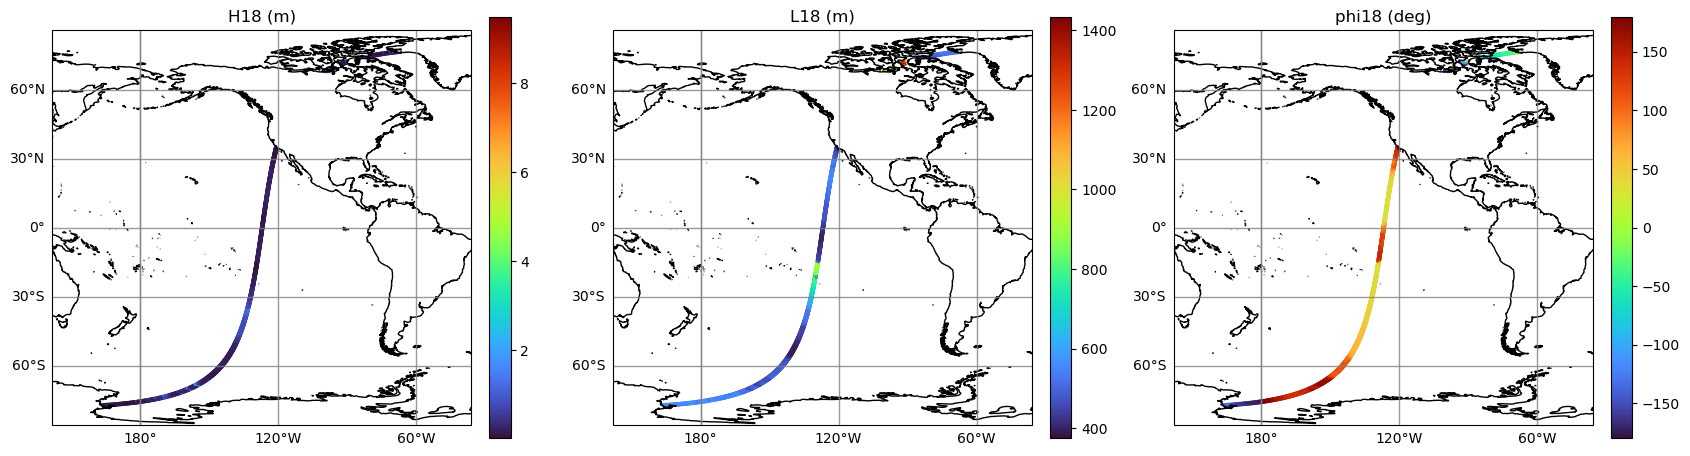

In [20]:
central_lon = ds_box['longitude'].values[ds_box.sizes['n_box']//2]

f, axs = plt.subplots(
    1, 
    len(integrated_wparams), 
    figsize=(17,7), 
    sharex=True, 
    sharey=True,   
    subplot_kw={'projection':ccrs.PlateCarree(central_longitude=central_lon)}
)

for i, v in enumerate(integrated_wparams):
    ax = axs[i]
    ax = custom_ax(ax)

    im = ax.scatter(
        ds_box.longitude, 
        ds_box.latitude, 
        c= ds_box[v], 
        s=1, 
        cmap='turbo',
        transform=ccrs.PlateCarree()
    )
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04) 
    ax.set_title(integrated_wparams_titles[i])

plt.tight_layout()
plt.show()

## Zoom into specific region: show 𝐻18, wave direction with arrows and quality flag

- Show 𝐻18 with wave direction
- Show quality flag
- Select arbitrary point and show box indices

### Geographical parameters

In [21]:
lat_target = 20
lat_start_plot = lat_target - 2
lat_stop_plot = lat_target + 2

Subset data with latitude range

In [22]:
lat=ds_box['latitude'].values
idx = np.where(
    (lat >= lat_start_plot) & 
    (lat <= lat_stop_plot)
)
ds_sel = ds_box.isel(n_box=slice(idx[0][0], idx[0][-1]))

Update min and max longitudes for the plot

In [23]:
lon_start_plot = np.min(ds_sel['longitude'].values)
lon_stop_plot = np.max(ds_sel['longitude'].values)

Select closest point to target latitude

In [24]:
ind = np.argmin(abs(ds_sel.latitude.values - lat_target))

### Quality flag
The quality flag is a bitwise flag

See [User handbook](https://www.aviso.altimetry.fr/fileadmin/documents/data/tools/hdbk_SWOT_L3_LR_WIND_WAVE.pdf) (section 2.6)

<div class="alert alert-warning"><b>Warning</b><p>
 The flag mask 16 is missing in the metadata. This will be fixed in the next version of the product
</p></div>

So we set ``flag_masks`` attribute with the missing value

In [25]:
ds_sel.quality_flag.attrs['flag_masks'] = [0, 2, 4, 8, 16, 4096, 32768]

Display flag masks -> meanings

In [26]:
dict(
        zip(
            ds_sel.quality_flag.attrs["flag_masks"],
            ds_sel.quality_flag.attrs["flag_meanings"].split(" "),
        )
)

{0: 'good',
 2: 'suspect_energy_ratio',
 4: 'suspect_number_of_tiles',
 8: 'suspect_separated_mask_clusters',
 16: 'suspect_H18_model',
 4096: 'degraded_no_model',
 32768: 'bad_no_data'}

Discrete colormap values. Limits between 0 and 10 (higher values are possible but they are not present in this plot)

In [27]:
flag_masks = [0, 2, 4, 6, 8, 10]

### Plot

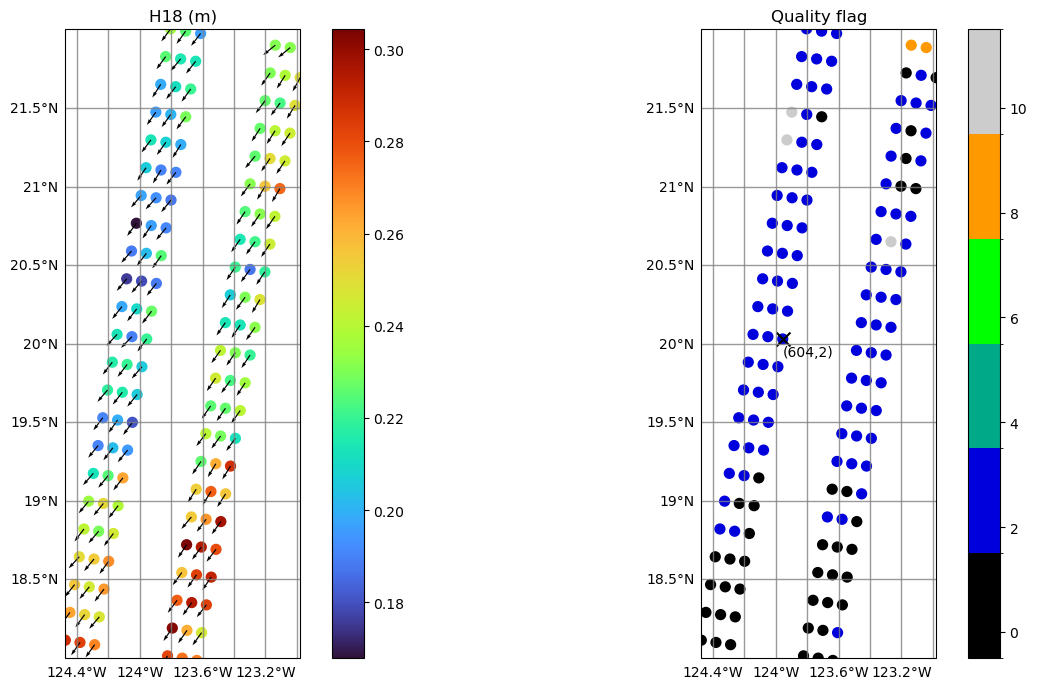

In [28]:
central_lon = ds_sel['longitude'].values[ds_sel.sizes['n_box']//2]

f, axs = plt.subplots(
    1, 
    2, 
    figsize=(15,7), 
    sharex=True, 
    sharey=True,          
    subplot_kw={'projection':ccrs.PlateCarree(central_longitude=central_lon)}
)

# Plot H18
ax = custom_ax(axs[0], extent=[lon_start_plot, lon_stop_plot, lat_start_plot, lat_stop_plot])

im = ax.scatter(
    ds_sel.longitude, 
    ds_sel.latitude, 
    c= ds_sel['H18'], 
    s=50, 
    cmap='turbo',
    transform=ccrs.PlateCarree()
)
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04) 
ax.set_title('H18 (m)')

# Plot phi18: "TO" convention
ax.quiver(
    ds_sel['longitude'].values,
    ds_sel['latitude'].values,
    -np.sin(ds_sel['phi18'].values* (np.pi / 180)), 
    -np.cos(ds_sel['phi18'].values* (np.pi / 180)), 
    angles='uv',color='black', 
    scale=15,
    transform=ccrs.PlateCarree()
)

# Plot flag
ax = custom_ax(axs[1], extent=[lon_start_plot, lon_stop_plot, lat_start_plot, lat_stop_plot])

# Discrete colormap. Limits between 0 and 10 (higher
# values are possible but they are not present in this
# plot)
cmap = plt.cm.nipy_spectral
vmin_cbar = 0
vmax_cbar = 10
norm = colors.BoundaryNorm(np.arange(vmin_cbar-0.5, vmax_cbar+2, 2), cmap.N)

im = ax.scatter(
    ds_sel.longitude, 
    ds_sel.latitude, 
    c= ds_sel['quality_flag'], 
    s=50, 
    cmap=cmap,
    norm=norm, 
    transform=ccrs.PlateCarree()
)
cbar = plt.colorbar(
    im, 
    ax=ax, 
    ticks=flag_masks,
    fraction=0.046, pad=0.04
) 

ax.set_title('Quality flag')

# Show selected point and respective box indices
ax.scatter(
    ds_sel.longitude[ind], ds_sel.latitude[ind],
    marker='x',
    s=100,
    c='k',
    transform=ccrs.PlateCarree()
)
ax.text(
    ds_sel.longitude[ind], 
    ds_sel.latitude[ind]-0.04, 
    '(%d,%d)'%(ds_sel['box_indy'].values[ind], ds_sel['box_indx'].values[ind]), 
    verticalalignment='top',
    transform=ccrs.PlateCarree()
)

plt.tight_layout()
plt.show()

## Using box indices to get original SSHA

The variables ``box_indx`` and ``box_indy`` are provided to locate the position of each box within the swath, corresponding to the cross-track and along-track directions, respectively.

The ``box_indx`` values are defined as follows:

* 0–1 for 40 km boxes (left or right swath)
* 0-5 for 20 km boxes (0–2 for the left swath and 3–5 for the right swath in the satellite frame)
* 0–13 for 10 km boxes (0–6 for the left swath and 7–13 for the right swath in the satellite frame)

See [User handbook](https://www.aviso.altimetry.fr/fileadmin/documents/data/tools/hdbk_SWOT_L3_LR_WIND_WAVE.pdf) (section 2.2)

### Show box indices

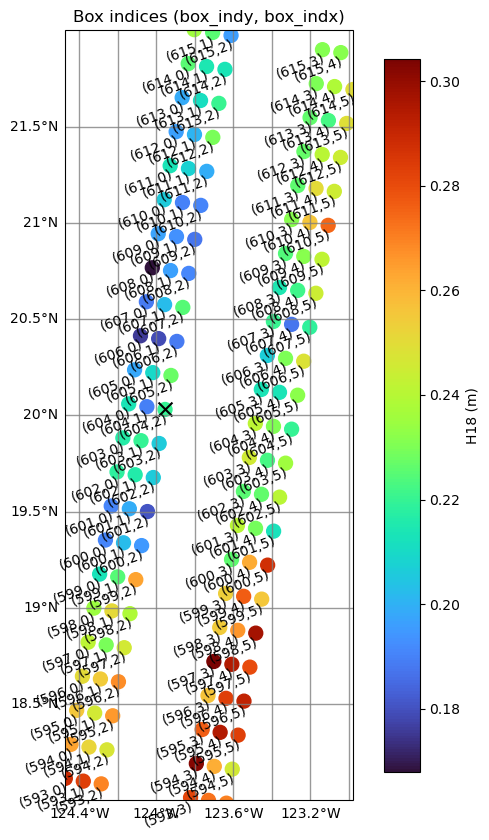

In [29]:
zoom_coords = [lon_start_plot, lon_stop_plot, lat_start_plot, lat_stop_plot]

central_lon = ds_sel['longitude'].values[ds_sel.sizes['n_box']//2]

f, ax = plt.subplots(
    1, 
    1, 
    figsize=(10,10), 
    subplot_kw={'projection':ccrs.PlateCarree(central_longitude=central_lon)}
)

ax = custom_ax(ax, extent=zoom_coords)

im = ax.scatter(
    ds_sel.longitude, 
    ds_sel.latitude, 
    c= ds_sel['H18'], 
    s=100, 
    cmap='turbo',
    transform=ccrs.PlateCarree()
)
cbar = plt.colorbar(im, ax=ax, 
    fraction=0.046, pad=0.04)
cbar.set_label('H18 (m)')

for box_y, box_x, lat, lon in zip(ds_sel['box_indy'].values, \
                                  ds_sel['box_indx'].values, \
                                  ds_sel['latitude'].values, \
                                  ds_sel['longitude'].values):
    if (zoom_coords[2]<=lat) & (zoom_coords[3]>=lat): 
        ax.text(lon-0.25, lat-0.01, 
                '(%d,%d)'%(box_y, box_x), 
            verticalalignment='top',
            rotation = 20,
            transform=ccrs.PlateCarree())
    else:
        continue

ax.scatter(
    ds_sel.longitude[ind], 
    ds_sel.latitude[ind],
    marker='x',
    s=100,
    c='k',
    transform=ccrs.PlateCarree()
)

ax.set_title('Box indices (box_indy, box_indx)')

plt.show()

### Get original SSHA

Plot SSH from L3 SSH product used for estimating spectra in L3 WW product

In [30]:
box_indices = ds_sel['box_indices'][ind].values.astype(int)

In [31]:
ds_ssh=xr.open_dataset(swot_l3_unsmoothed_file)[['latitude', 'longitude', 'ssha_unfiltered', 'quality_flag']]

In [32]:
box_ssh =  ds_ssh.isel(num_lines=slice(box_indices[0],box_indices[1]), num_pixels=slice(box_indices[2],box_indices[3]))
box_ssh['longitude'] = (box_ssh['longitude'] + 180)%360 - 180

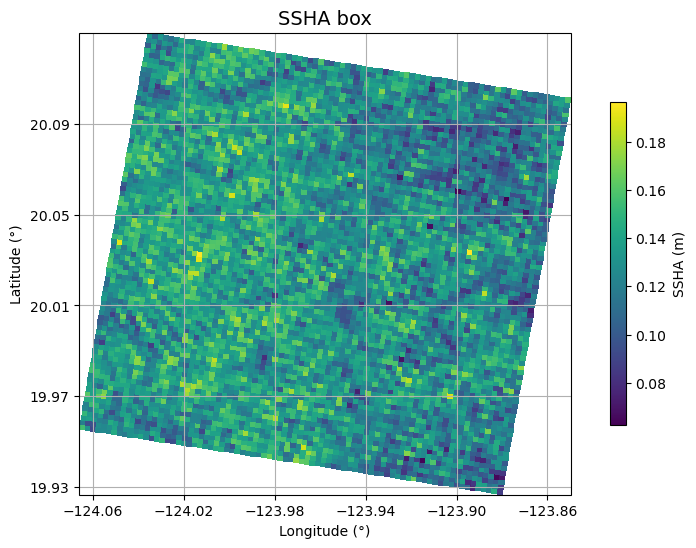

In [33]:
box_ssh['ssha_filtered'] = box_ssh['ssha_unfiltered'].where(
            (box_ssh['quality_flag'] == 0)
            |(box_ssh['quality_flag'] == 10)
            |(box_ssh['quality_flag'] == 20))

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor="lightgray")

im = ax.pcolormesh(
    box_ssh.longitude, 
    box_ssh.latitude, 
    box_ssh['ssha_filtered'], 
    transform=ccrs.PlateCarree()
)

cbar = plt.colorbar(im, orientation="vertical", ax=ax, shrink=0.7, label="SSHA (m)")

ax.set_title("SSHA box", fontsize=14)
ax.set_xlabel("Longitude (°)")
ax.set_ylabel("Latitude (°)")
xticks = np.arange(np.round(np.min(box_ssh.longitude),2), 
                   np.round(np.max(box_ssh.longitude),2),
                   0.04)
yticks = np.arange(np.round(np.min(box_ssh.latitude),2), 
                   np.round(np.max(box_ssh.latitude),2),
                   0.04)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.grid()

plt.show()

## Plot KaRIn spectrum
SSHA-based 2-dimensional wave spectra, for waves with periods longer than ~500 m (18 s)

Unsmoothed KaRIn data has a spatial posting of ~250 m so the smallest observable wavelength is ~500 m, which is equivalent to ~18 s through the wave dispersion equation. For this reason, integrated wave parameters are denoted with the suffix “18” as 𝐻18 (significant wave height), 𝐿18 (wavelength) and ϕ_18 (wave direction).

The estimation of the wave heights PSD starts with the computation of the KaRIn SSHA power spectral density. The estimation is performed for each spatial box. 

See [User handbook](https://www.aviso.altimetry.fr/fileadmin/documents/data/tools/hdbk_SWOT_L3_LR_WIND_WAVE.pdf) (section 2.3)

### Plot KaRIn spectrum provided in cartesian coordinates

Express frequencies in km-1

In [34]:
fx2 = ds_tile['fx2D'].values*1e3
fy2 = ds_tile['fy2D'].values*1e3

Get mask and integrated wave parameters

In [35]:
xmask, ymask = get_mask_border(
    ds_sel['swell_mask'][ind].values,
    fx2[0,:],                  
    fy2[:,0]
)
L18 = ds_sel['L18'][ind].values*1e-3 # in km
phi18_NE = ds_sel['phi18'][ind].values
H18 = ds_sel['H18'][ind].values

Get wave direction in SWOT reference system

In [36]:
phi18_SWOT = rotate_angle_from_NE_to_SWOT_ref_system(
    phi18_NE, 
    ds_sel['track_angle'][ind].values
)

Plot

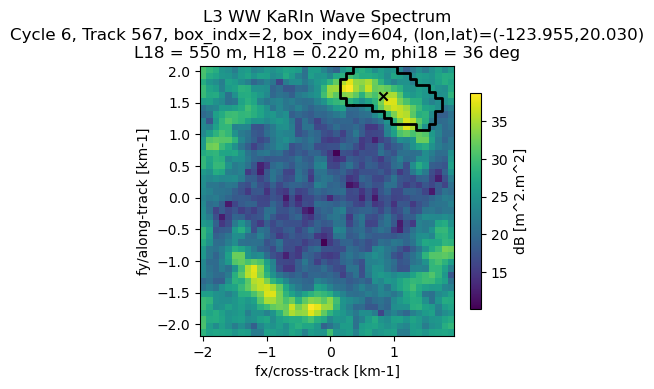

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(4.1, 3.5))
im=ax.pcolormesh(
    fx2,
    fy2, 
    10*np.log10(ds_sel['Efxfy_SWOT'][ind].values), 
    cmap='viridis',
    rasterized=True
)
ax.set_xlabel("fx/cross-track [km-1]")
ax.set_ylabel("fy/along-track [km-1]")
cbar=plt.colorbar(im,ax=ax,label='dB [m^2.m^2]', shrink=0.8)

# Plot mask and swell barycenter
ax.plot(xmask, ymask, linewidth=2, color='k')
ax.scatter(
    1/L18*np.sin(np.deg2rad(phi18_SWOT)),
    1/L18*np.cos(np.deg2rad(phi18_SWOT)),
    marker = 'x',
    color = 'k'
)
info_sample_str = 'Cycle %d, Track %d, box_indx=%d, box_indy=%d, (lon,lat)=(%.3f,%.3f)\n'% (cycle_number,
                                                                 pass_number,
                                                                 ds_sel['box_indx'][ind].values,
                                                                 ds_sel['box_indy'][ind].values,
                                                                 ds_sel['longitude'][ind].values,
                                                                 ds_sel['latitude'][ind].values) + \
                    'L18 = %d m, H18 = %.3f m, phi18 = %d deg' % (L18*1e3,
                                                                    H18,
                                                                    phi18_NE
                                                                    )
ax.set_title('L3 WW KaRIn Wave Spectrum\n' + info_sample_str)
plt.show()

### Plot KaRIn spectrum provided in polar coordinates

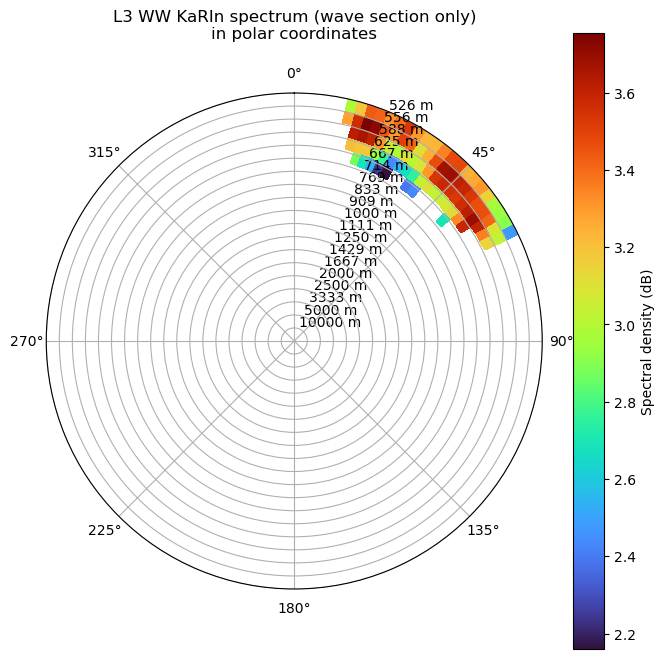

In [41]:
f =  ds_tile.f_vector.data
phi = ds_tile.phi_vector.data
S_fphi = ds_sel.isel(n_box=ind).E_f_phi_SWOT_masked.data

# Étendre les axes pour pcolormesh
F = np.linspace(f.min(), f.max(), len(f) + 1) 
PHI = np.linspace(phi.min(), phi.max(), len(phi) + 1)
F_grid, PHI_grid = np.meshgrid(F, PHI, indexing="ij")

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

plot = ax.pcolormesh(PHI_grid, F_grid, np.log10(S_fphi), shading='flat', cmap='turbo')
plt.colorbar(plot, label="Spectral density (dB)")

f_ticks = f[1:]
T_ticks = 1 / f_ticks  
ax.set_yticks(f_ticks)  
ax.set_yticklabels([f"{T:.0f} m" for T in T_ticks]) 

ax.set_theta_zero_location("N")  
ax.set_theta_direction(-1)  

ax.set_title("L3 WW KaRIn spectrum (wave section only)\nin polar coordinates", pad=20)

plt.show()

### Undo KaRIn instrument corrections (show original KaRIn spectrum)

At the end of the processing chain, the KaRIn SSHA power spectral density (i.e. the "wave spectrum") is corrected by dividing it by an approximation of the KaRIn transfer function. This one accounts mainly for the azimuth point target response (PTR), the on-board averaging filters and the azimuth cutoff effect. This correction is done on the assumption that the KaRIn processing is linear and many other considerations have been omitted (see handbook). For this reason, the user should have this in mind when using KaRIn corrected wave spectra. 

The corrected spectrum if provided in both the Light and the Extended files. In addition, the Extended product provides the KaRIn transfer function correction, so the user can undo the correction if necessary (note that the filter aliasing cannot be undone, but this should not change the interpretation of results).

In [39]:
S_swot_original = ds_sel['Efxfy_SWOT'][ind].values * \
                  ds_tile['filter_OBP'].values * \
                  ds_tile['filter_PTR'].values * \
                  np.exp(-((fy2/1e3 * ds_sel['lambdac_model'][ind].values) ** 2)) # restore fy into m-1 (lambdac is given in m)

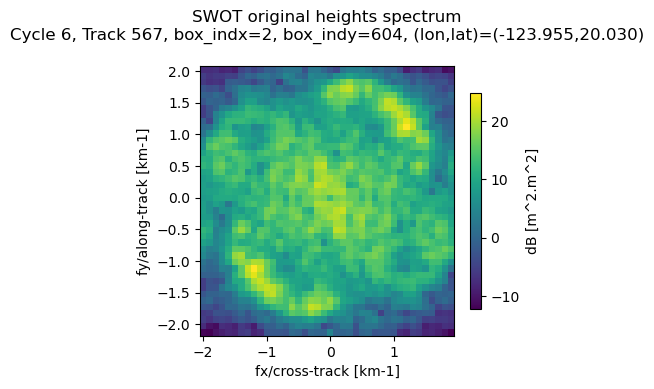

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(4.1, 3.5))
im=ax.pcolormesh(
    fx2,
    fy2, 
    10*np.log10(S_swot_original), 
    cmap='viridis',
    rasterized=True
)
ax.set_xlabel("fx/cross-track [km-1]")
ax.set_ylabel("fy/along-track [km-1]")
cbar=plt.colorbar(
    im,
    ax=ax,
    label='dB [m^2.m^2]', 
    shrink=0.8
)

info_sample_str = 'Cycle %d, Track %d, box_indx=%d, box_indy=%d, (lon,lat)=(%.3f,%.3f)\n'% (cycle_number,
                                                                 pass_number,
                                                                 ds_sel['box_indx'][ind].values,
                                                                 ds_sel['box_indy'][ind].values,
                                                                 ds_sel['longitude'][ind].values,
                                                                 ds_sel['latitude'][ind].values)
ax.set_title('SWOT original heights spectrum\n' + info_sample_str)
plt.show()